In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
import pathlib
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda,  BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras import applications

from time import time

# Parameters

In [2]:
learning_rate = 0.001  # initial learning rate
min_learning_rate = 0.00001  # once the learning rate reaches this value, do not decrease it further
learning_rate_reduction_factor = 0.001  # the factor used when reducing the learning rate -> learning_rate *= learning_rate_reduction_factor
patience = 1  # how many epochs to wait before reducing the learning rate when the loss plateaus
verbose = 1  # controls the amount of logging done during training and testing: 0 - none, 1 - reports metrics after each batch, 2 - reports metrics after each epoch
image_size = (100, 100)  # width and height of the used images
input_shape = (100, 100, 3)  # the expected input shape for the trained models; since the images in the Fruit-360 are 100 x 100 RGB images, this is the required input shape

# Directories

In [19]:
use_label_file = False  # set this to true if you want load the label names from a file; uses the label_file defined below; the file should contain the names of the used labels, each label on a separate line
label_file = 'labels.txt'
base_dir = r'C:\Users\Previato\Images360'  # relative path to the Fruit-Images-Dataset folder
test_dir = pathlib.Path(base_dir) / 'Test'
train_dir = pathlib.Path(base_dir) / 'Training'

output_dir = 'Results'  # root folder in which to save the the output files; the files will be under output_files/model_name 

In [24]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.strip() for x in f.readlines()]
else:
    labels = [dir_name for dir_name in os.listdir(train_dir)]
    labels = list(set(labels))
#     labels = np.array(sorted(labels))
num_classes = len(labels)

In [5]:
list_ds = tf.data.Dataset.list_files(str(train_dir / '*/*'))

In [6]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # resize the image to the desired size
#   return tf.image.resize(img, [img_height, img_width])
  return img


def process_path(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    label = tf.strings.split(label, " ")[0]
    label = tf.argmax(label == labels)
    
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    return img, label

In [7]:
for f in list_ds.take(5):
    print(f.numpy())
    print(process_path(f))

b'C:\\Users\\Previato\\Fruit-Images-Dataset\\Training\\Cherry\\273_100.jpg'
(<tf.Tensor: shape=(100, 100, 3), dtype=uint8, numpy=
array([[[254, 255, 253],
        [254, 255, 253],
        [254, 255, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 253],
        [255, 255, 253],
        [254, 255, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 253],
        [255, 255, 253],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
       

In [8]:
labeled_ds = list_ds.map(process_path)

In [9]:
for f in labeled_ds.take(5):
    print(f)

(<tf.Tensor: shape=(100, 100, 3), dtype=uint8, numpy=
array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 2

In [10]:
print(labels)
print(num_classes)

['Apricot' 'Avocado' 'Banana' 'Beetroot' 'Blueberry' 'Cactus' 'Cantaloupe'
 'Carambola' 'Cauliflower' 'Cherry' 'Chestnut' 'Clementine' 'Cocos' 'Corn'
 'Cucumber' 'Dates' 'Eggplant' 'Fig' 'Ginger' 'Granadilla' 'Grape'
 'Grapefruit' 'Green' 'Guava' 'Hazelnut' 'Huckleberry' 'Kaki' 'Kiwi'
 'Kohlrabi' 'Kumquats' 'Lemon' 'Limes' 'Lychee' 'Mandarine' 'Mango'
 'Mangostan' 'Maracuja' 'Melon' 'Mulberry' 'Nectarine' 'Nut' 'Onion'
 'Orange' 'Papaya' 'Passion' 'Peach' 'Pear' 'Pepino' 'Pepper' 'Physalis'
 'Pineapple' 'Pitahaya' 'Plum' 'Pomegranate' 'Pomelo' 'Potato' 'Quince'
 'Rambutan' 'Raspberry' 'Red' 'Redcurrant' 'Salak' 'Strawberry'
 'Tamarillo' 'Tangelo' 'Tomato' 'Walnut' 'Watermelon']
68


In [13]:
image_count = len(labeled_ds)

In [14]:
image_count

67692

In [15]:
int(67692 * 0.2)

13538

In [16]:
batch_size = 50

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_data = configure_for_performance(labeled_ds.skip(13538))
val_data = configure_for_performance(labeled_ds.take(13538))

In [17]:
model = network_cnnPaper(input_shape=input_shape, num_classes=num_classes)

NameError: name 'network_cnnPaper' is not defined

In [ ]:
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [52]:
model.fit(train_data, epochs=1)

1084/1084 [==============================] - 32s 30ms/step - loss: 0.8496 - accuracy: 0.8060


In [56]:
model.predict(val_data)

array([[3.7539817e-06, 4.7579526e-08, 1.9128334e-04, ..., 4.2998199e-03,
        4.0115260e-06, 2.1479955e-06],
       [6.6358275e-08, 1.9253295e-07, 9.2431083e-03, ..., 7.0612870e-05,
        2.3316037e-08, 8.4015383e-08],
       [3.4349328e-06, 1.3194845e-07, 3.9335922e-07, ..., 5.5080345e-03,
        1.2069478e-05, 1.4938541e-08],
       ...,
       [1.8096341e-06, 6.5260509e-05, 1.1563222e-05, ..., 8.3148602e-04,
        8.2949526e-05, 4.0738425e-07],
       [1.6764268e-14, 2.8447185e-13, 4.7350599e-11, ..., 1.6297620e-14,
        4.7605459e-17, 1.0156030e-17],
       [3.5097769e-06, 3.2093556e-06, 2.1186415e-07, ..., 9.9594313e-01,
        8.9189029e-07, 2.1170042e-06]], dtype=float32)

# Plots

In [5]:
# create 2 charts, one for accuracy, one for loss, to show the evolution of these two metrics during the training process
def plot_model_history(model_history,name):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))
    axs[1].legend(['train', 'val'], loc='best')
    # save the graph in a file called "acc_loss.png" to be available for later; the model_name is provided when creating and training a model
    if name:
        plt.savefig(name)
    plt.show()

In [6]:
# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true, y_pred, classes, name):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(40, 40))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt=".3f", linewidths=.2, cbar_kws={"shrink": 0.8})
    if name:
        plt.savefig(name)  # as in the plot_model_history, the matrix is saved in a file called "model_name_confusion_matrix.png"
    return plt

# Image processing

In [7]:
def convert_image(x, alpha=1.5, beta=0):
    import cv2
    return cv2.convertScaleAbs(x, alpha=alpha, beta=beta)

In [8]:
# Create a custom layer that converts the original image from
# RGB to HSV and grayscale and concatenates the results
# forming in input of size 100 x 100 x 4
def convert_to_hsv_and_grayscale(x):
    import tensorflow as tf
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    rez = tf.concat([hsv, gray], axis=-1)
    return rez

In [9]:
# Randomly changes hue and saturation of the image to simulate variable lighting conditions
def augment_image(x):
    import tensorflow as tf
    x = tf.image.random_saturation(x, 0.9, 1.2)
    x = tf.image.random_hue(x, 0.02)
    return x

In [10]:
def resize_image(x):
    import cv2
    width = int(224)
    height = int(224)
    dim = (width, height)
    return cv2.resize(x, dim)

# Build Train, Validation and Test data

In [21]:
# given the train and test folder paths and a validation to test ratio, this method creates three generators
#  - the training generator uses (100 - validation_percent) of images from the train set 
#    it applies random horizontal and vertical flips for data augmentation and generates batches randomly
#  - the validation generator uses the remaining validation_percent of images from the train set
#    does not generate random batches, as the model is not trained on this data
#    the accuracy and loss are monitored using the validation data so that the learning rate can be updated if the model hits a local optimum
#  - the test generator uses the test set without any form of augmentation
#    once the training process is done, the final values of accuracy and loss are calculated on this set
def build_data_generators(train_folder, test_folder, validation_percent, labels=None, image_size=(224, 224), batch_size=50, convert=True):
    
    if convert:
        train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,  # randomly flip images
            preprocessing_function=convert_image, 
            validation_split=validation_percent)  # percentage indicating how much of the training set should be kept for validation

        test_datagen = ImageDataGenerator(preprocessing_function=convert_image)
    
    else:
        train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,  # randomly flip images,
            validation_split=validation_percent)  # percentage indicating how much of the training set should be kept for validation

        test_datagen = ImageDataGenerator()

    
    train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=True, subset='training', classes=labels)
    validation_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                       batch_size=batch_size, shuffle=False, subset='validation', classes=labels)
    test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                batch_size=batch_size, shuffle=False, subset=None, classes=labels)
    return train_gen, validation_gen, test_gen

# Train, evaluate and Predict

In [12]:
trainGen, validationGen, testGen = build_data_generators(train_dir, test_dir, validation_percent=0.1, labels=labels, image_size=image_size, batch_size=50, convert=True)

Found 30304 images belonging to 68 classes.
Found 3356 images belonging to 68 classes.
Found 11300 images belonging to 68 classes.


In [22]:
# this method performs all the steps from data setup, training and testing the model and plotting the results
# the model is any trainable model; the input shape and output number of classes is dependant on the dataset used, in this case the input is 100x100 RGB images and the output is a softmax layer with 118 probabilities
# the name is used to save the classification report containing the f1 score of the model, the plots showing the loss and accuracy and the confusion matrix
# the batch size is used to determine the number of images passed through the network at once, the number of steps per epochs is derived from this as (total number of images in set // batch size) + 1
def train_and_evaluate_model(model, conf, epochs=25, batch_size=50, verbose=verbose, useCkpt=False, convert=True):
    print(model.summary())
    
    conf = conf + str(convert)
    model_name = "/model" + "-" + conf + ".h5"
    model_out_dir = output_dir
  
    trainGen, validationGen, testGen = build_data_generators(train_dir, test_dir, validation_percent=0.1, labels=labels, image_size=image_size, batch_size=batch_size, convert=convert)
    optimizer = Adam(lr=learning_rate)
    
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose, 
                                                factor=learning_rate_reduction_factor, min_lr=min_learning_rate)
    save_model = ModelCheckpoint(filepath=model_out_dir + model_name, monitor='val_accuracy', verbose=verbose, 
                                 save_best_only=True, save_weights_only=False, mode='max', period=1)
    #tbCallBack = TensorBoard(log_dir="logs/fc_normal".format(time()), write_graph=True)
    history = model.fit(trainGen,
                                  epochs=epochs,
                                  steps_per_epoch=(trainGen.n // batch_size) + 1,
                                  validation_data=validationGen,
                                  validation_steps=(validationGen.n // batch_size) + 1,
                                  verbose=verbose,
                                  callbacks=[learning_rate_reduction, save_model]
                                   #callbacks = [tbCallBack]
                       )

    model.load_weights(model_out_dir + model_name)

    validationGen.reset()
    loss_v, accuracy_v = model.evaluate(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)
    loss, accuracy = model.evaluate(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))
    
    plot_model_history(history, name=model_out_dir+"/acc_loss-"+conf+".png")
    testGen.reset()
    y_pred = model.predict(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    y_true = testGen.classes[testGen.index_array]
    plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, name=model_out_dir+"/confusion_matrix-"+conf+".png")
    class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)

    with open(model_out_dir + "/classification_report-" + conf + ".txt", "w") as text_file:
        text_file.write("%s" % class_report)

# Networks

In [14]:
def network_one(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(img_input)
    x = Activation('elu', name='conv1_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='conv2')(x)
    x = Activation('elu', name='conv2_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='conv3')(x)
    x = Activation('elu', name='conv3_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='conv4')(x)
    x = Activation('elu', name='conv4_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', name='fcl2')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

In [15]:
def network_two(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(img_input)
    x = Activation('elu', name='conv1_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='conv2')(x)
    x = Activation('elu', name='conv2_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='conv3')(x)
    x = Activation('elu', name='conv3_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='conv4')(x)
    x = Activation('elu', name='conv4_elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

In [16]:
def network_three(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(16, (5, 5), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu', name='fcl2')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

In [17]:
def network_cnnPaper(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(convert_to_hsv_and_grayscale)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

In [31]:
model = network_one(input_shape=input_shape, num_classes=num_classes)


In [32]:
print(model.summary)

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x000002C2DE0F6DF0>>


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1216      
_________________________________________________________________
conv1_elu (Activation)       (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 25, 25, 32)        12832     
_________________________________________________________________
conv2_elu (Activation)       (None, 25, 25, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 12, 12, 32)       

<ipython-input-5-42a560a92260>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
<ipython-input-5-42a560a92260>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))


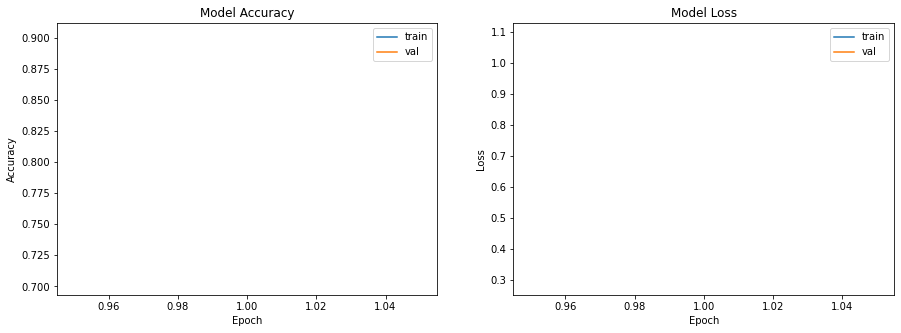

454/454 [==============================] - 11s 23ms/step


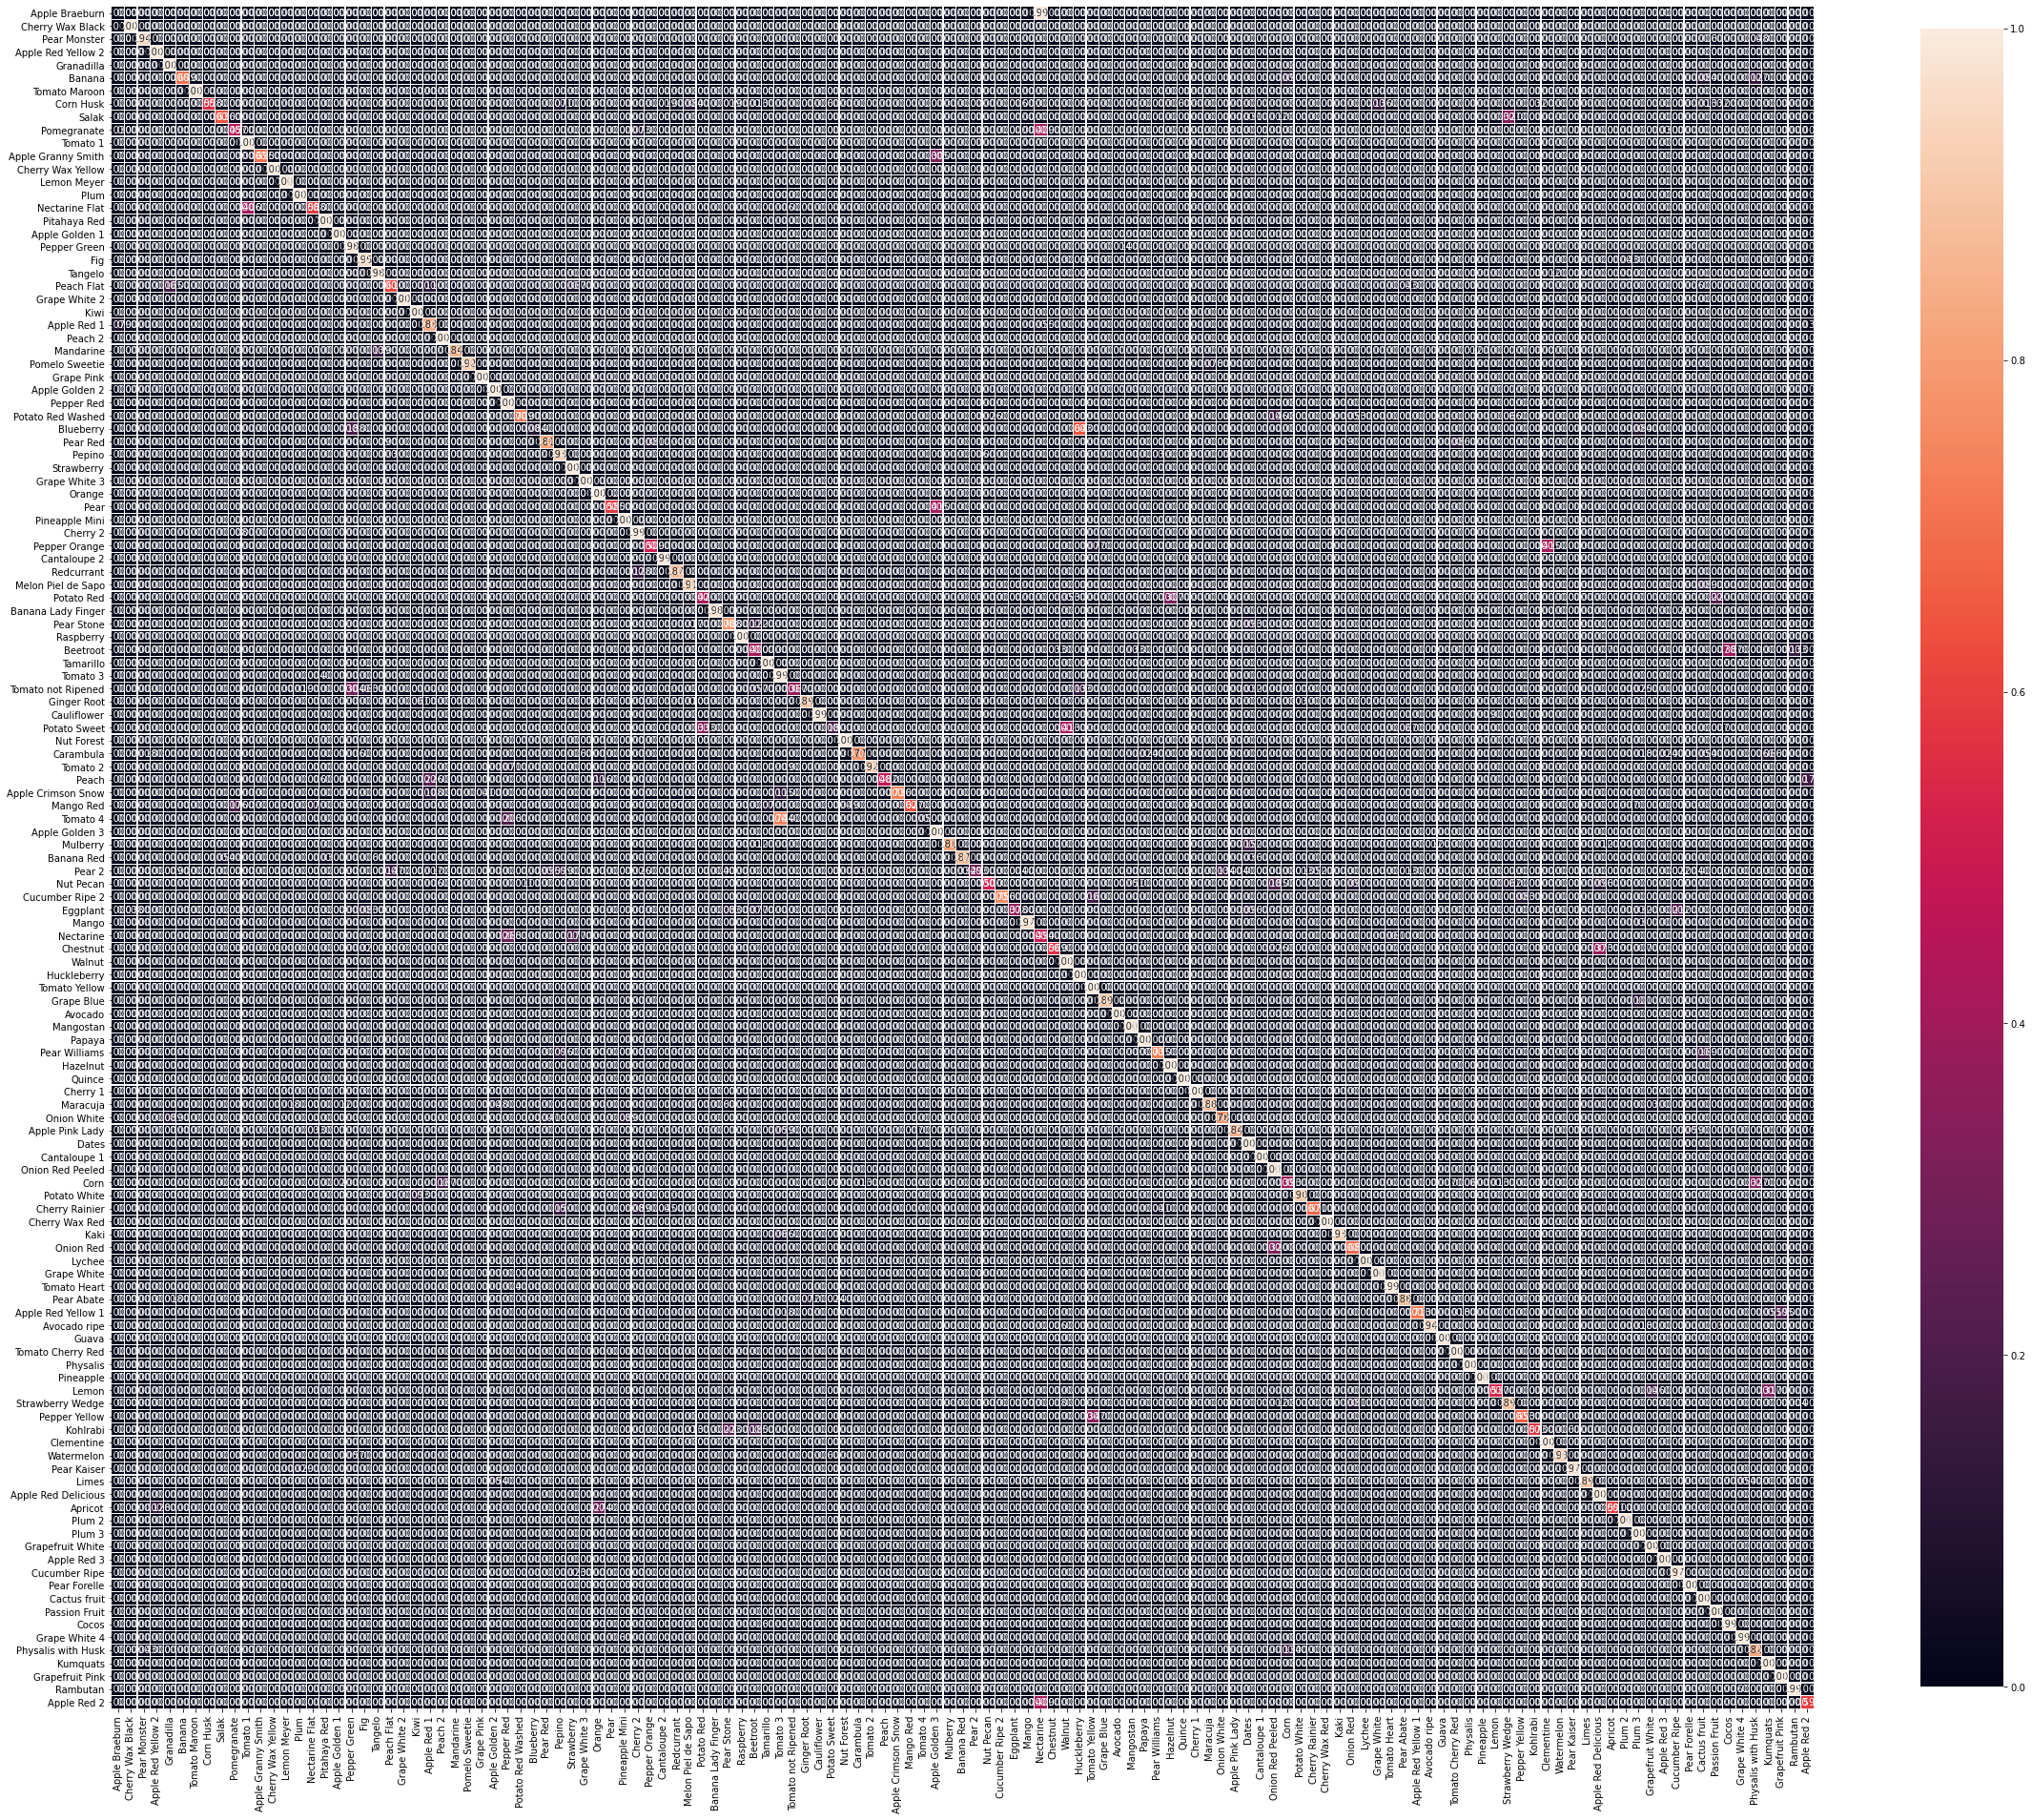

In [25]:
model = network_one(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, conf="conf1", epochs=1, convert=True)

In [ ]:
model = network_one(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, conf="conf2", epochs=25, convert=True)

In [28]:
model = network_three(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, conf="conf3", epochs=25, convert=True)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        2432      
_________________________________________________________________
conv1_relu (Activation)      (None, 50, 50, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
conv2 (Conv2D)               (None, 13, 13, 64)        51264     
_________________________________________________________________
conv2_relu (Activation)      (None, 13, 13, 64)       

KeyboardInterrupt: 

In [ ]:
model = network_cnnPaper(input_shape=input_shape, num_classes=num_classes)
#train_and_evaluate_model(model, conf="paper", epochs=25, convert=False)#aqui usa o data_augmentation -- teria que acertar na função

# Transfer Learn - VGG16

In [13]:
image_size = (100, 100)
def build_data_generatorsTransfer(train_folder, test_folder, validation_percent, labels=None, image_size=(224, 224), batch_size=50, convert=True):
    
    if convert:
        train_datagen = ImageDataGenerator(
            rescale = 1./255,
            horizontal_flip=True,
            vertical_flip=True,  # randomly flip images
            #preprocessing_function=resize_image, 
            validation_split=validation_percent)  # percentage indicating how much of the training set should be kept for validation

        test_datagen = ImageDataGenerator(rescale = 1./255)#preprocessing_function=resize_image,rescale = 1./255)
    
    else:
        train_datagen = ImageDataGenerator(
            rescale = 1./255,
            horizontal_flip=True,
            vertical_flip=True,  # randomly flip images
            #preprocessing_function=resize_image,
            validation_split=validation_percent)  # percentage indicating how much of the training set should be kept for validation

        test_datagen = ImageDataGenerator(rescale = 1./255)#preprocessing_function=resize_image,rescale = 1./255)

    
    train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=True, subset='training', classes=labels)
    validation_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                       batch_size=batch_size, shuffle=False, subset='validation', classes=labels)
    test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                batch_size=batch_size, shuffle=False, subset=None, classes=labels)
    return train_gen, validation_gen, test_gen

In [14]:
from tensorflow import keras
import cv2

class CustomMetricsCallback(keras.callbacks.Callback):
    def __init__(self, labels, testGen, batch_size):
        super(CustomMetricsCallback, self).__init__()
        self.labels = labels
        self.testGen = testGen
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.testGen, steps=(self.testGen.n // self.batch_size) + 1)
        y_true = self.testGen.classes[self.testGen.index_array]
        plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), self.labels, name="batch_conf.png")
        img = cv2.imread("batch_conf.png")
        
        ret = tf.summary.image("conf_matrix", np.expand_dims(img, 0), step=epoch)
        
#         if not hasattr(self.model.optimizer, "lr"):
#             raise ValueError('Optimizer must have a "lr" attribute.')
#         # Get the current learning rate from model's optimizer.
#         lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
#         # Call schedule function to get the scheduled learning rate.
#         scheduled_lr = self.schedule(epoch, lr)
#         # Set the value back to the optimizer before this epoch starts
#         tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
#         print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))

In [15]:
import tensorflow as tf
from datetime import datetime

def train_and_evaluate_modelTransfer(model, conf, epochs=25, batch_size=50, verbose=verbose, useCkpt=False, convert=True):
    print(model.summary())
    
    conf = conf + str(convert)
    model_name = "/model" + "-" + conf + ".h5"
    model_out_dir = output_dir
  
    trainGen, validationGen, testGen = build_data_generatorsTransfer(train_dir, test_dir, validation_percent=0.1, labels=labels, image_size=image_size, batch_size=batch_size, convert=convert)
    
    logdir = "logs/fc_normal-%s" % (datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
    
    file_writer = tf.summary.create_file_writer(logdir + "/metrics")
    file_writer.set_as_default()
    
    
#     Found 30267 images belonging to 107 classes.
#     Found 60948 images belonging to 107 classes.
#     Found 3357 images belonging to 107 classes.
#     Found 6744 images belonging to 107 classes.
#     Found 11168 images belonging to 107 classes.
#    Found 22688 images belonging to 107 classes.
    
    tbCallBack = TensorBoard(log_dir=logdir, write_graph=True, update_freq=10)
    history = model.fit(trainGen,
                                  epochs=epochs,
                                  steps_per_epoch=(trainGen.n // batch_size) + 1,
                                  validation_data=validationGen,
                                  validation_steps=(validationGen.n // batch_size) + 1,
                                  verbose=verbose,
                                  #callbacks=[learning_rate_reduction, save_model]
                                   callbacks = [tbCallBack, CustomMetricsCallback(labels, validationGen, batch_size)]
                       )

    model.load_weights(model_out_dir + model_name)

    validationGen.reset()
    loss_v, accuracy_v = model.evaluate(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)
    loss, accuracy = model.evaluate(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))
    
    plot_model_history(history, name=model_out_dir+"/acc_loss-"+conf+".png")
    testGen.reset()
    y_pred = model.predict(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    y_true = testGen.classes[testGen.index_array]
    plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, name=model_out_dir+"/confusion_matrix-"+conf+".png")
    class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)

    with open(model_out_dir + "/classification_report-" + conf + ".txt", "w") as text_file:
        text_file.write("%s" % class_report)

In [22]:
model = applications.vgg16.VGG16(weights = None , include_top=False, input_tensor=Input(shape=(100, 100, 3)))

In [23]:
#Congelando os pesos da Arquitetura e retreinando ultimo bloco de convoluções + FC
# for i in range (15):
#    model.layers[i].trainable = False

#Adicionando Camada de Classificação
#x = model.layers[-1].output
#x = Flatten()(x)
#x = Dense(4096, activation='relu', name='fc1')(x)
#x = Dense(4096, activation='relu', name='fc2')(x)
#prediction = Dense(num_classes, activation='softmax', name='predictions')(x)
#model_final = Model(model.inputs, prediction)

In [24]:
#Congelando os pesos da Arquitetura e deixando apenas os FC prontos para serem treinados
# for i in range (19):
#     model.layers[i].trainable = False
    #print('Layer ' + model.layers[i].name + ' frozen.')

#Adicionando Camada de Classificação 
x = model.layers[-1].output
x = Flatten()(x)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dense(256, activation='relu', name='fc2')(x)
prediction = Dense(num_classes, activation='softmax', name='predictions')(x)

model_final = Model(model.inputs, prediction)

In [49]:
import tensorflow.keras.metrics as metrics
import tensorflow.keras.backend as K

class CategoricalTruePositives(metrics.Metric):

    def __init__(self, num_classes, batch_size=50,
                 name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)

        self.batch_size = batch_size
        self.num_classes = num_classes    

        self.cat_true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):     

#         y_true = K.argmax(y_true, axis=-1)
        y_true = K.cast(y_true, dtype="float32")
        y_pred = K.argmax(y_pred, axis=-1)
        y_pred = K.cast(y_pred, dtype="float32")
        y_true = K.flatten(y_true)

        true_poss = K.sum(K.cast((K.equal(y_true, y_pred)), dtype=tf.float32))

        self.cat_true_positives.assign_add(true_poss)

    def result(self):

        return self.cat_true_positives

class BatchAccuracy(metrics.Metric):

    def __init__(self, batch_size=50,
                 name="batch_accuracy", **kwargs):
        super(BatchAccuracy, self).__init__(name=name, **kwargs)

        self.batch_size = batch_size 

        self.batch_acc = self.add_weight(name="bacc", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):     

#         y_true = K.argmax(y_true, axis=-1)
        y_true = K.cast(y_true, dtype="float32")
        #K.print_tensor(K.shape(y_true))
        y_pred = K.argmax(y_pred, axis=-1)
        y_pred = K.cast(y_pred, dtype="float32")
        # K.print_tensor(K.shape(y_pred))
        y_true = K.flatten(y_true)

        true = K.sum(K.cast(K.equal(y_true, y_pred), dtype=tf.float32))
        #K.print_tensor(K.cast(K.equal(y_true, y_pred), dtype=tf.float32))
        #K.print_tensor(K.shape(K.equal(y_true, y_pred)))

        # K.print_tensor(K.int_shape(y_pred))
        self.batch_acc.assign(true / K.cast(K.shape(y_pred), dtype=tf.float32)[0])

    def result(self):

        return self.batch_acc

In [50]:
from tensorflow.keras import optimizers
import tensorflow.keras.metrics as metrics

optimizer = Adam(lr=learning_rate)

batch_size = 50

model_final.compile(loss = "sparse_categorical_crossentropy",
                    optimizer = optimizer,
                    metrics=["accuracy",
                             "sparse_categorical_accuracy",
#                              metrics.AUC(),
                             CategoricalTruePositives(num_classes, batch_size=batch_size),
                             BatchAccuracy(batch_size=batch_size)
                            ]
                   )

In [ ]:
train_and_evaluate_modelTransfer(model_final, conf="transferFC", epochs=25, batch_size=batch_size, convert=False)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

Epoch 13/25
1825/1825 [==============================] - 429s 235ms/step - loss: 0.1446 - accuracy: 0.9531 - sparse_categorical_accuracy: 0.9531 - categorical_true_positives: 86938.0000 - batch_accuracy: 0.9000 - val_loss: 0.3530 - val_accuracy: 0.9124 - val_sparse_categorical_accuracy: 0.9124 - val_categorical_true_positives: 9218.0000 - val_batch_accuracy: 1.0000
Epoch 14/25
1825/1825 [==============================] - 430s 236ms/step - loss: 0.1293 - accuracy: 0.9577 - sparse_categorical_accuracy: 0.9577 - categorical_true_positives: 87355.0000 - batch_accuracy: 0.9600 - val_loss: 0.3977 - val_accuracy: 0.9037 - val_sparse_categorical_accuracy: 0.9037 - val_categorical_true_positives: 9130.0000 - val_batch_accuracy: 1.0000
Epoch 15/25
1825/1825 [==============================] - 429s 235ms/step - loss: 0.1573 - accuracy: 0.9495 - sparse_categorical_accuracy: 0.9495 - categorical_true_positives: 86603.0000 - batch_accuracy: 0.9600 - val_loss: 0.3572 - val_accuracy: 0.9151 - val_spars